# Bicycle trajectory forecasting in Bologna

## 1 - Data processing

In this Notebook we take a look at our database, which contains some anonymised tracks of pedestrians and cyclists moving across the city of Bologna during the spring and summer of 2017.

The data were previously processed, and we obtain them as sequences of integers, representing 200 m * 200 m squares
in a 40 * 57 rectangular grid spanning from (lat, lon) to (lat, lon), over Bologna.
The sequences represent a sampling performed every 10 s. 

In this sense, if an integer is repeated N times within a sequence, we understand that the correspondent cyclist's trajectory has fallen within the associated square for a time of N * 10 s.

We are interested in the prevision of the geometry of the trajectory, so we want to extrapolate, given a portion of it, a forecast for the next grid cell visited.

This notebook has been used to explore the data and cast it in useful forms for the training of machine learning algorithms.

First, let us import some useful modules and set some paths to the data.

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import os
import numpy as np

In [3]:
datafolder = "/home/giulio/DATI/encoded_200_data/"
files = os.listdir(datafolder)
files.sort()

In [4]:
for f in files:
    print(f)

04a_encoded_200.csv
04b_encoded_200.csv
05a_encoded_200.csv
05b_encoded_200.csv
06a_encoded_200.csv
06b_encoded_200.csv
07a_encoded_200.csv
07b_encoded_200.csv
08a_encoded_200.csv
08b_encoded_200.csv
09a_encoded_200.csv
09b_encoded_200.csv


The data is broken down into roughly bi-weekly files. With the available computing power it has been possible
to process only a single month at a time, as an example in the following we will consider the month of May (files ```05a_encoded_200.csv``` and ```05b_encoded_200.csv```), but changing the slicing indices in the initialisation of ```aggregate_files```  allows the processing and aggregation of any combination of the bi-weekly files.

In [5]:
li = []

aggregate_files = files[2:4]

print(aggregate_files)

for filename in aggregate_files:
    df = pd.read_csv(datafolder+filename)
    li.append(df)

ed = pd.concat(li, axis=0, ignore_index=True)

ed

['05a_encoded_200.csv', '05b_encoded_200.csv']


,Activity,Type,Timestamp,Coding
0,1564059,0,1.493590e+09,1233
1,1564059,0,1.493590e+09,1233
2,1564059,0,1.493590e+09,1233
3,1564059,0,1.493590e+09,1233
4,1564059,0,1.493590e+09,1233
...,...,...,...,...
34229982,2116927,0,1.496631e+09,636
34229983,2116927,0,1.496631e+09,636
34229984,2116927,0,1.496631e+09,636
34229985,2116927,0,1.496631e+09,636


Each record represents a coded location in a trajectory. The features are
* `Activity` is a trajectory unique integer, identifying the trip within the database,
* `Type` is `0` for pedestrian trips, `1` for cyclists,
* `Timestamp` is a Unix timestamp for the coded location,
* `Coding` contains the location code.

in the following we may refer to the location code as to a character, in the analogy with the outcomes of an information source, as it is defined in information theory.

We break the database into `Activity`-indexed dictionaries containing the trajectory and the trajectory length.

In [6]:
e_pedestrian_trips  = {k : trip.to_numpy() for k, trip in ed.groupby(ed.Activity) if trip.Type.iloc[0] == 0}
e_bike_trips        = {k : trip.to_numpy() for k, trip in ed.groupby(ed.Activity) if trip.Type.iloc[0] == 1}

e_pedestrian_points = np.array([t.shape[0] for t in e_pedestrian_trips.values()])
e_bike_points       = np.array([t.shape[0] for t in e_bike_trips.values()])

Building a histogram of the trip lenghts we observe that there are no trips shorter than 90, as in the pre-existent
processing trips shorter than 15 minutes were discarded. Moreover we observe a longer tail for pedestrians, in consequence of the lower speed that they can attain with respect to bicycles, thus leading to a prolonged transit time through each cell.

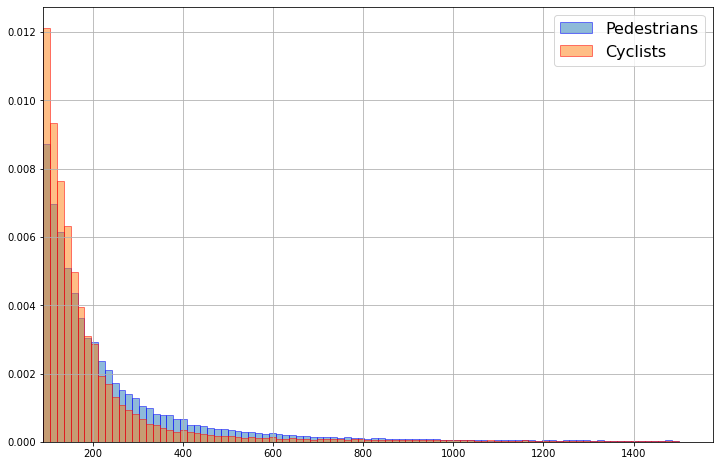

In [7]:
efig, eax = plt.subplots(figsize = (12,8))
plt.hist(e_pedestrian_points, bins = np.linspace(0, 1500, 100), alpha = .5, density = True, 
         edgecolor='blue', linewidth=1, label = "Pedestrians")
plt.hist(e_bike_points, bins = np.linspace(0, 1500, 100), alpha = .5, density = True, 
         edgecolor='red', linewidth=1, label = "Cyclists")
plt.xlim(left = 90)
plt.grid(True)
plt.legend(fontsize = 16)

In [8]:
e_pedestrian_seqs          = {k : trip[:,3] for k, trip in e_pedestrian_trips.items()}
e_bike_seqs                = {k : trip[:,3] for k, trip in e_bike_trips.items()}

from more_itertools import unique_justseen

e_pedestrian_unique_seqs   = {k : np.fromiter(unique_justseen(trip), dtype = int) for k, trip in e_pedestrian_seqs.items()}
e_bike_unique_seqs         = {k : np.fromiter(unique_justseen(trip), dtype = int) for k, trip in e_bike_seqs.items()}

e_unique_pedestrian_points = np.array([t.shape[0] for t in e_pedestrian_unique_seqs.values()])
e_unique_bike_points       = np.array([t.shape[0] for t in e_bike_unique_seqs.values()])

To keep only the information about the trajectory geometry we remove character repetitions, by collapsing repeated consecutive characters into a single one, e.g. `AAAAABBBBBBBAACCCCCCB -> ABACB`.

In consequence of this we observe that the trajectory length distributions are changed quite radically: while the pedestrians' one is peaked around 10 locations, the cyclists' is peaked around 20.

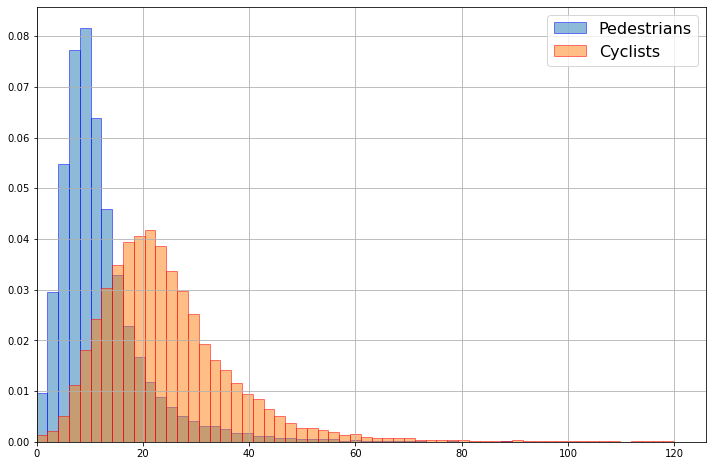

In [9]:
e_unique_fig, e_unique_ax  = plt.subplots(figsize = (12,8))

plt.hist(e_unique_pedestrian_points, bins = np.linspace(0, 120, 60), density = True, alpha = .5, 
         edgecolor='blue', linewidth=1., label = "Pedestrians")
plt.hist(e_unique_bike_points, bins = np.linspace(0, 120, 60), density = True,  alpha = .5, 
         edgecolor='red', linewidth=1, label = "Cyclists")
plt.xlim(left = 0)
plt.grid(True)
plt.legend(fontsize = 16)

Due to the higher number of visited locations, we choose to perform our ML experiments on the cyclists.

We extract from the trips sequences of `threshold` locations, with an offset of `pred` within each other, when the two are taken from the same trip. The idea is to predict the last `pred` locations, using the remainder of the sequence.

Notice that the choice taken here does not automatically propagate to the other parts of the project, but rather sets how many sequences can be obtained from each trip.

Notice also that the parts of the projects employing "jump" encoding (explained below), only support prediction of the next location, i.e. `pred = 1`.

In [11]:
threshold = 12
pred      = 1
(sum(e_unique_bike_points < threshold), sum(e_unique_bike_points >= threshold))

(3653, 32951)

Discard all trips shorter than `threshold`.

In [12]:
sufficient_bike_seqs = {k : seq for k, seq in e_bike_unique_seqs.items() if len(seq) >= threshold}

In [13]:
processed_bike_seqs = []

for seq in sufficient_bike_seqs.values():
    n_useful_seqs   = int(np.floor(len(seq) - threshold + 1)/pred)
    for i in range(n_useful_seqs):
        sseq        = np.roll(seq, -i * pred)[:threshold]
        processed_bike_seqs.append(sseq)

This helper function is used to turn each character into a pair of real numbers, akin to bidimensional cartesian coordinates, in the $\left[-1, 1\right]^{\times 2}$ domain. An example of the output of the function is provided.

We subsequently scale the coordinates of a factor $10$, effectively moving to the $\left[-10, 10\right]^{\times 2}$ domain.

In [14]:
def to_scaled(n):
    return np.array([2 * (n % 57) / 57 -1 , - 2 * (n // 57) / 40 + 1])
to_scaled(np.array([it for it in processed_bike_seqs[0]]))

array([[-0.64912281, -0.64912281, -0.64912281, -0.61403509, -0.57894737,
        -0.54385965, -0.50877193, -0.47368421, -0.47368421, -0.43859649,
        -0.40350877, -0.40350877],
       [-0.15      , -0.2       , -0.25      , -0.25      , -0.25      ,
        -0.25      , -0.2       , -0.2       , -0.15      , -0.15      ,
        -0.15      , -0.1       ]])

In [15]:
final_array = np.array(processed_bike_seqs)

final_bidimensional = 10 * np.array(to_scaled(final_array))
final_bidimensional.shape

(2, 512882, 12)

Save the sequences to file. We save both a version in the original encoding and one in the bidimensional format, flattening the vector.

In [16]:
import csv

with open("../../preproc/september_encoded_bike.csv", mode="w") as fout:
    wr = csv.writer(fout)
    for row in final_array:
        wr.writerow(row)
        
with open("../../preproc/september_encoded_bike_bidimensional.csv", mode="w") as fout:
    wr = csv.writer(fout)
    for row_x, row_y in zip(final_bidimensional[0], final_bidimensional[1]):
        wr.writerow(np.concatenate((row_x, row_y)))

Since the data only contain continuous trajectories, we can encode them also by providing the first 11 locations in the bidimensional format and the direction of the last jump as an integer from 0 to 7, indicating the relative position of the last character with respect to the second-to-last, within its *Moore neighbourhood*, i.e. both the sideways and diagonally adjacent.

We choose by convention to start from above with 0 and proceed through to 7 in a clockwise fashion.

In [18]:
bd_data = pd.read_csv("../../preproc/september_encoded_bike_bidimensional.csv", header = None).to_numpy()

read = 11
pred = 12 - read

assert pred > 0

X = np.concatenate((bd_data[:,:read], bd_data[:,12:12+read]), axis = 1)
Y = np.concatenate((bd_data[:,read: 12], bd_data[:,12+read:24]), axis = 1)

def xy_to_ij(arr):
    if len(arr.shape) == 3: # Array of double arrays
        return np.array([xy_to_ij(a) for a in arr])
    if len(arr.shape) == 2: # Array of flattened double arrays or double array
        if arr.shape[0] >2: # Check this
            return np.array([xy_to_ij(a) for a in arr])
        prep = arr / 10 
        ret = []
        for it in prep.T:
            ret.append(np.round([57/2*(1+it[0]), -20*(it[1]-1) ]))
        return np.array(ret)
    if len(arr.shape) == 1: # Flattened array
        prep = arr.reshape(2, -1) / 10
        ret = []
        for it in prep.T:
            ret.append(np.round([57/2*(1+it[0]), -20*(it[1]-1) ]))
        return np.array(ret)

def code_to_ij(arr):
    if len(arr.shape) == 2: # Array of arrays
        return np.array([code_to_ij(a) for a in arr])
    if len(arr.shape) == 1: # Flattened array
        ret = []
        for code in arr:
            ret.append(np.array([code % 57, code // 57]))
        return np.array(ret)

X_r = X.reshape(X.shape[0],2,-1)
Y_r = Y.reshape(Y.shape[0],2,-1)

In [21]:
X_r.shape, Y_r.shape

((512882, 2, 11), (512882, 2, 1))

This function does the actual encoding, as specified above.

In [30]:
def encode_jump(first, second):
    diff = second-first
    #print(diff)
    if (diff[0] ==  1. and diff[1] ==  0.):
        return 0
    if (diff[0] ==  1. and diff[1] ==  1.):
        return 1
    if (diff[0] ==  0. and diff[1] ==  1.):
        return 2
    if (diff[0] == -1. and diff[1] ==  1.):
        return 3
    if (diff[0] == -1. and diff[1] ==  0.):
        return 4
    if (diff[0] == -1. and diff[1] == -1.):
        return 5
    if (diff[0] ==  0. and diff[1] == -1.):
        return 6
    if (diff[0] ==  1. and diff[1] == -1.):
        return 7

Y_jump = np.full(shape=(X.shape[0]), fill_value=-1)

for i, trj in enumerate(X_r):
    final = xy_to_ij(trj[:,-2:])
    #print(final)
    Y_jump[i] = encode_jump(final[0], final[1])
    #print(Y_jump[i])

KeyboardInterrupt: 

We write the data to a csv file, with the first 10 records of each row being the flattened series of bidimensional vectors, and a final integer encoding the jump.

In [ ]:
with open("./preproc/september_jump_encoded_bike.csv", mode="w") as fout:
    wr = csv.writer(fout)
    for row, y in zip(X, Y_jump):
        wr.writerow(np.concatenate((row, np.array([y]))))